In [2]:
# 1. 加载插件
%load_ext sql

In [3]:
# 2. 建立连接（注意相对路径）
# sqlite:/// 后面跟着的是你硬盘上的文件路径
%sql sqlite:///../data/olist.db

In [4]:
# 3. 提取数据并转为 Pandas Dataframe
import sqlite3
import pandas as pd

# 建立数据库连接（使用你已经验证过的相对路径）
conn = sqlite3.connect('../data/olist.db')

# 编写 SQL（注意：别名 order_count 加了下划线，避免空格报错）
sql_query = """
SELECT payment_type, COUNT(*) as order_count 
FROM olist_order_payments_dataset 
GROUP BY 1 
ORDER BY order_count DESC
"""

# 直接用 pandas 读取 SQL 结果，一步到位
df = pd.read_sql(sql_query, conn)

print("✅ 数据提取成功！前5行如下：")
display(df.head())

✅ 数据提取成功！前5行如下：


,payment_type,order_count
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


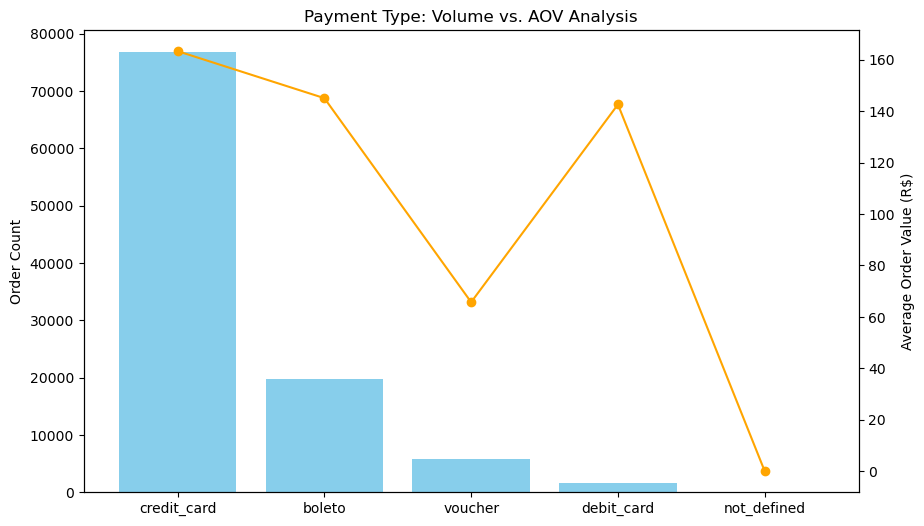

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
#1.1付款方式对订单数量的影响分析


# 1. 编写 SQL (直接复用你 DBeaver 调试好的逻辑)
query_aov = """
SELECT 
    payment_type, 
    COUNT(order_id) AS total_orders,
    AVG(payment_value) AS avg_order_value
FROM olist_order_payments_dataset
GROUP BY 1
ORDER BY total_orders DESC;
"""

# 2. 读取数据 (确保路径是 ../data/)
df_aov = pd.read_sql(query_aov, conn)

# 3. 绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 画柱状图 (订单量)
ax1.bar(df_aov['payment_type'], df_aov['total_orders'], color='skyblue', label='Order Volume')
ax1.set_ylabel('Order Count')

# 创建双轴画折线图 (AOV)
ax2 = ax1.twinx()
ax2.plot(df_aov['payment_type'], df_aov['avg_order_value'], color='orange', marker='o', label='AOV')
ax2.set_ylabel('Average Order Value (R$)')

plt.title('Payment Type: Volume vs. AOV Analysis')
plt.show()

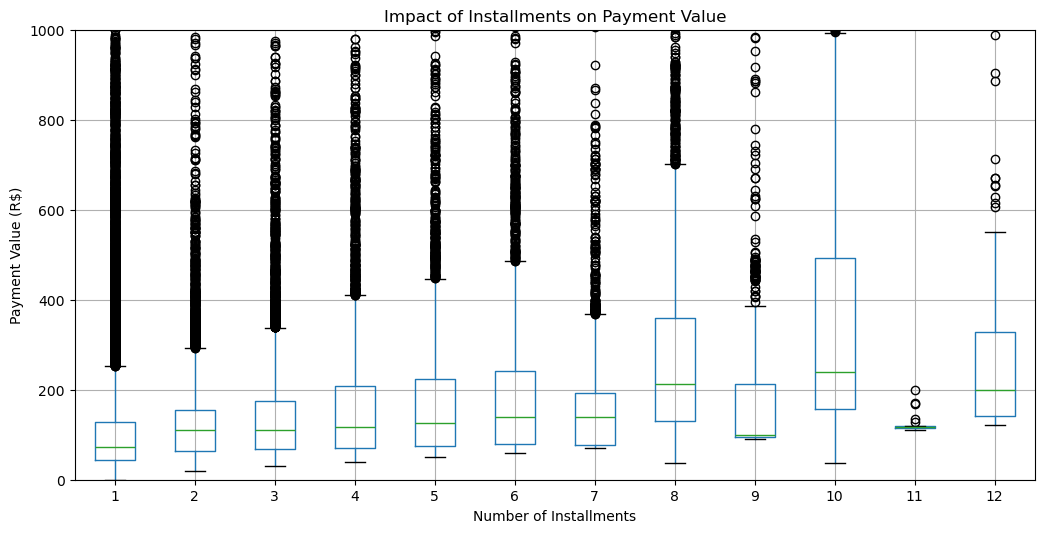

In [6]:
#1.2分期对订单金额的影响分析

# 1. 提取分期与金额数据
query_ins = "SELECT payment_installments, payment_value FROM olist_order_payments_dataset WHERE payment_installments > 0"
df_ins = pd.read_sql(query_ins, conn)

# 2. 过滤掉极极少数的超长分期，使图表更聚焦
df_filtered = df_ins[df_ins['payment_installments'] <= 12]

# 3. 画箱线图
df_filtered.boxplot(column='payment_value', by='payment_installments', figsize=(12, 6))
plt.title('Impact of Installments on Payment Value')
plt.suptitle('') # 去除自动生成的副标题
plt.xlabel('Number of Installments')
plt.ylabel('Payment Value (R$)')
plt.ylim(0, 1000) # 限制 Y 轴范围以便观察中位数变化
plt.show()

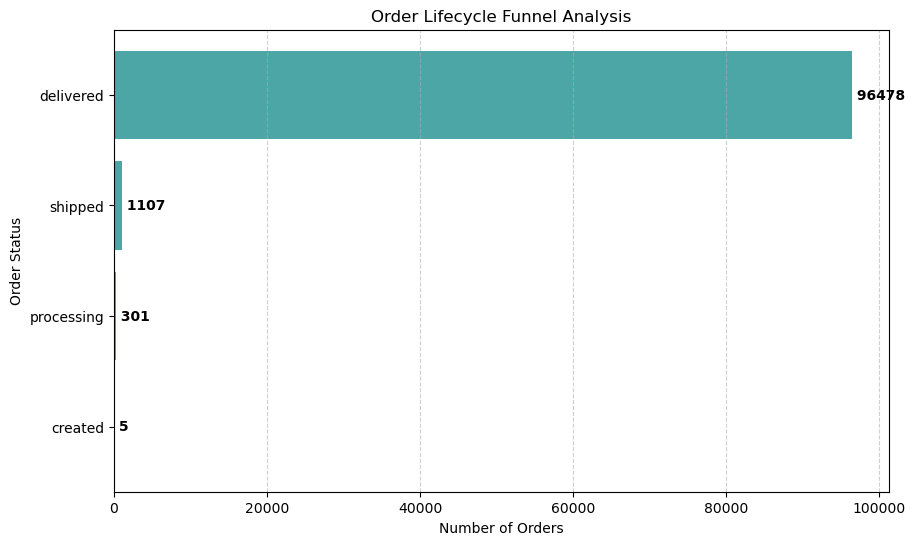

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 编写 SQL：按业务生命周期排序状态
# 注意：我们要手动定义漏斗的顺序，这样图表才有逻辑
query_funnel = """
SELECT order_status, COUNT(order_id) as count
FROM olist_orders_dataset
GROUP BY order_status
"""

# 2. 读取数据
df_status = pd.read_sql(query_funnel, conn)

# 3. 手动定义业务漏斗的逻辑顺序
# 下单 -> 已付款 -> 发货中 -> 已交寄 -> 已送达
funnel_order = ['created', 'processing', 'shipped', 'delivered']
df_status['order_status'] = pd.Categorical(df_status['order_status'], categories=funnel_order, ordered=True)
df_funnel = df_status.dropna().sort_values('order_status', ascending=True) # 倒序是为了画图时从上往下

# 4. 绘图
plt.figure(figsize=(10, 6))
plt.barh(df_funnel['order_status'], df_funnel['count'], color='teal', alpha=0.7)

# 5. 添加数据标签（重点：一眼看清流失）
for index, value in enumerate(df_funnel['count']):
    plt.text(value, index, f' {int(value)}', va='center', fontweight='bold')

plt.title('Order Lifecycle Funnel Analysis')
plt.xlabel('Number of Orders')
plt.ylabel('Order Status')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()